This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_sir
from stochastic_tests import Test
import stochastic_repro as sr

pd.set_option('display.max_rows', None)

t_fin = 10.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000]
                   )

beta1_mean = 2.0E-6
beta2_mean = 3.0E-6

test1 = Test(model=model_sir({'beta': ('norm', (beta1_mean, beta1_mean / 10))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_sir({'beta': ('norm', (beta2_mean, beta2_mean / 10))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

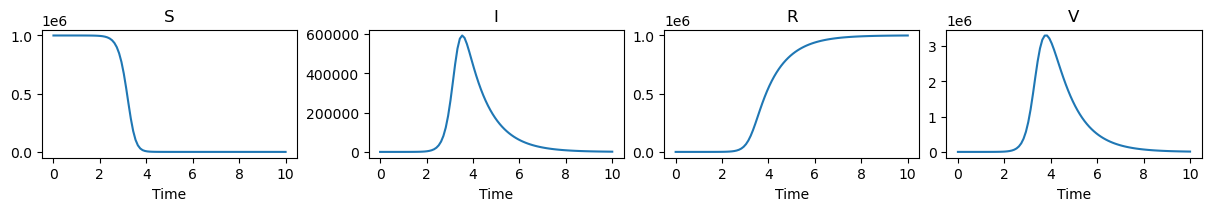

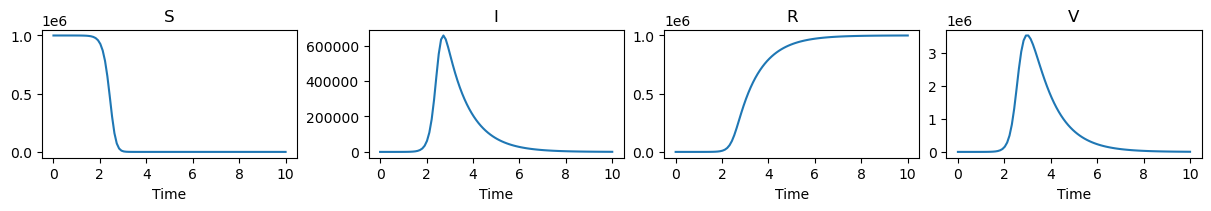

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

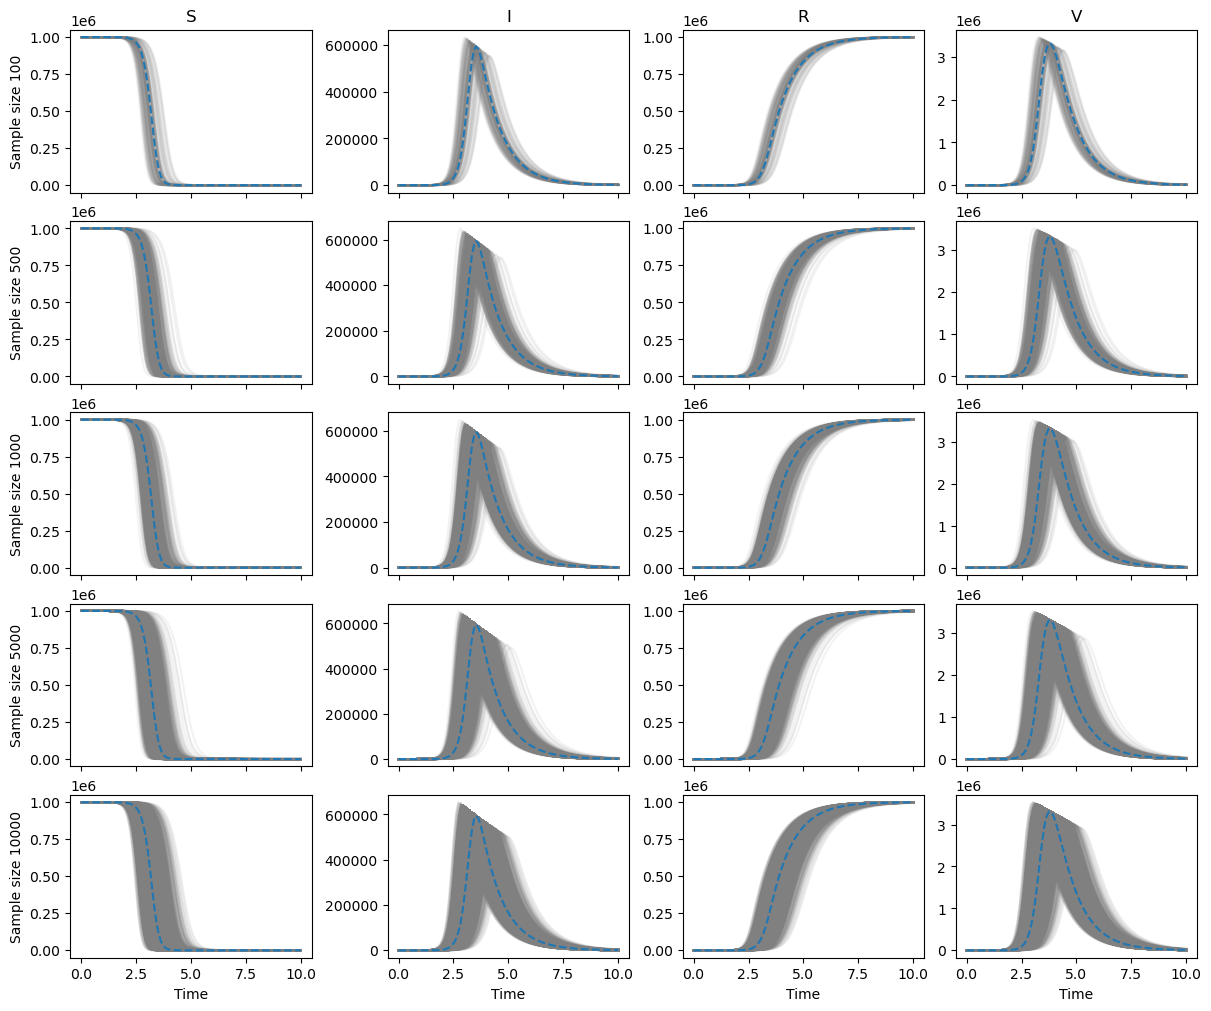

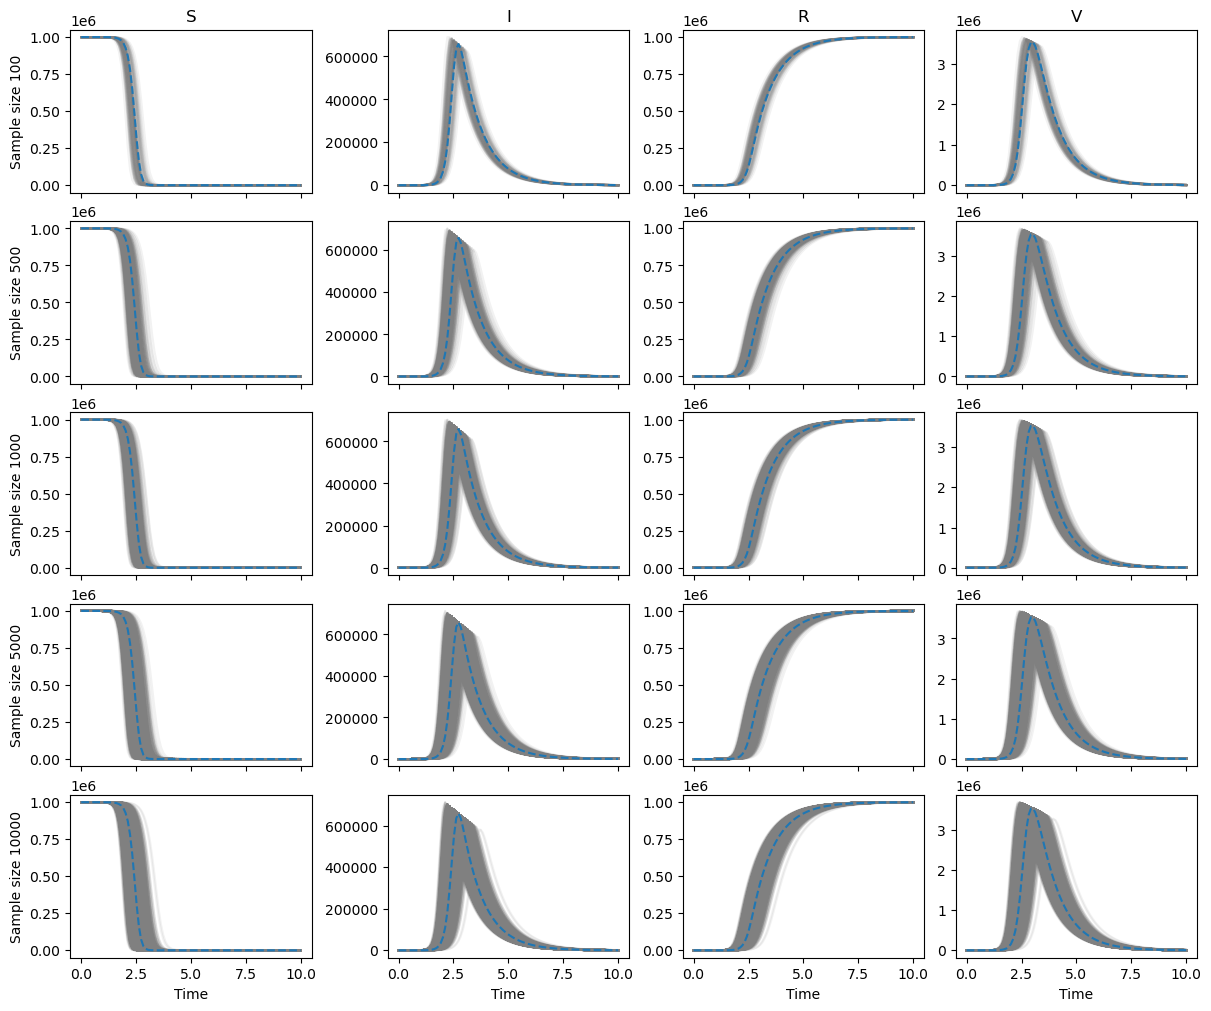

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

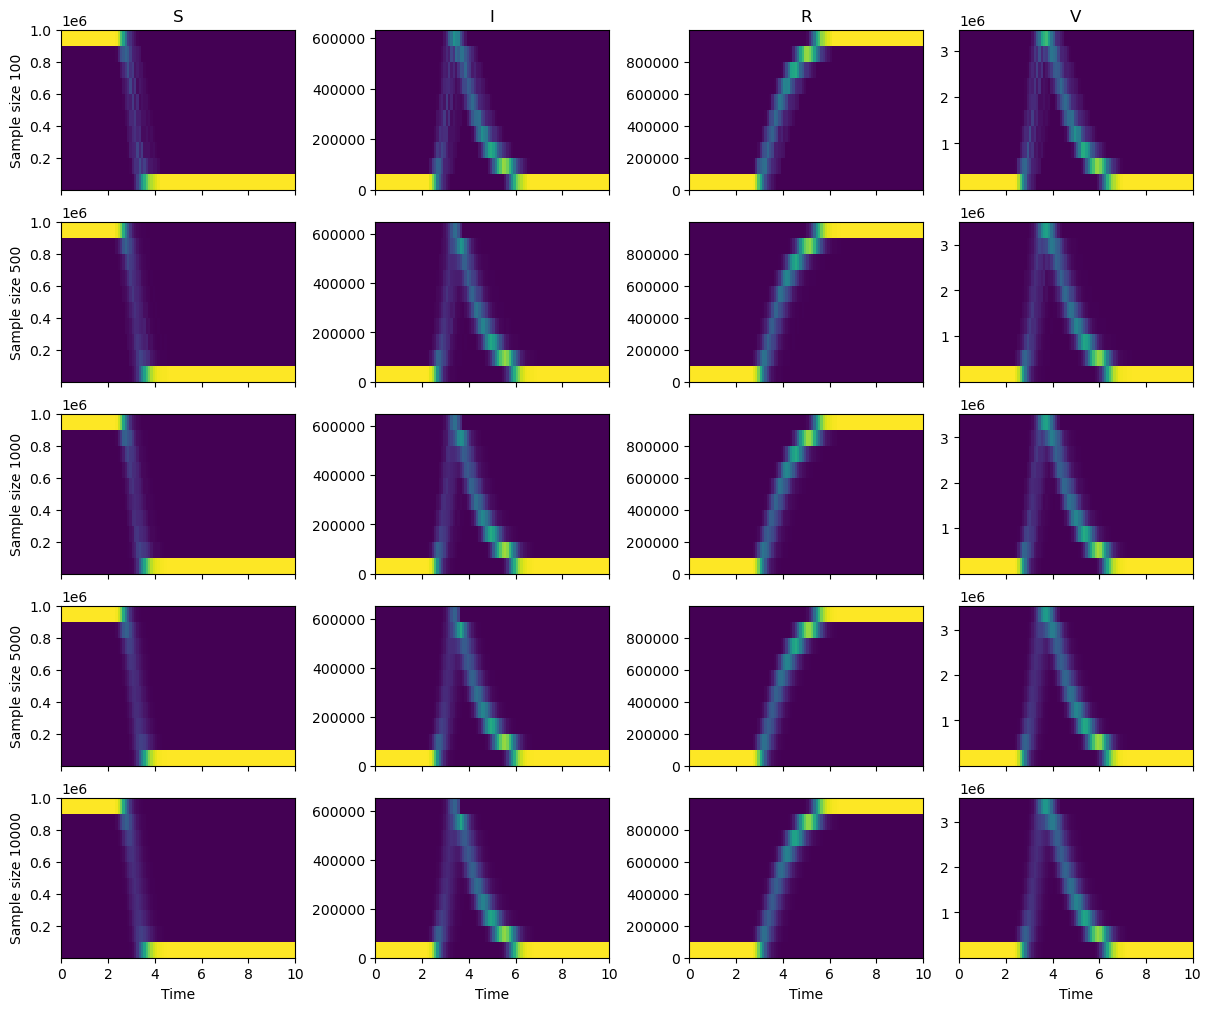

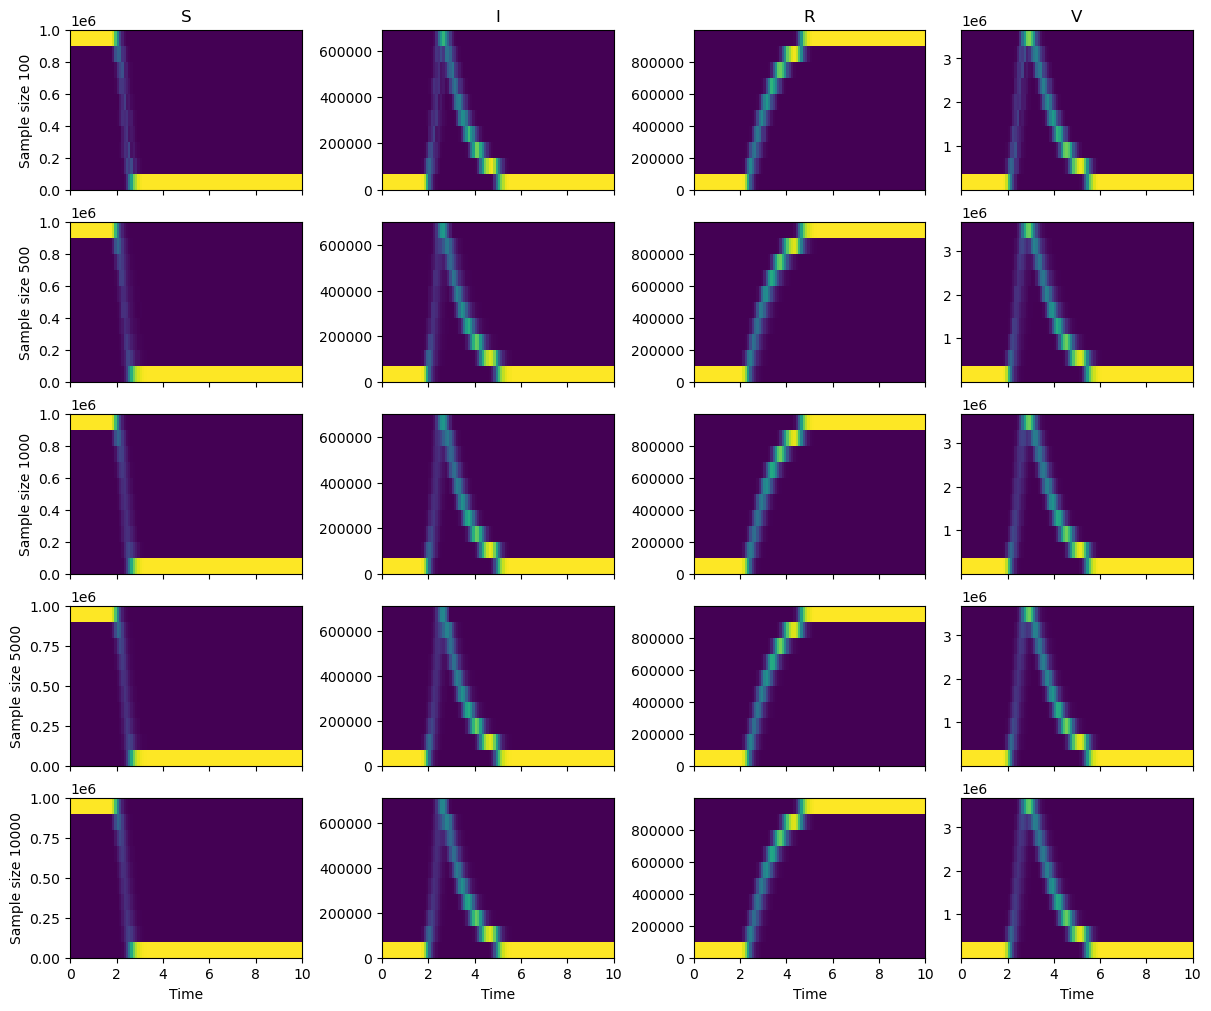

In [5]:
for test in tests:
    _ = test.plot_distributions()

C:\Users\timothy.sego\AppData\Local\miniconda3\envs\stoch_repro\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


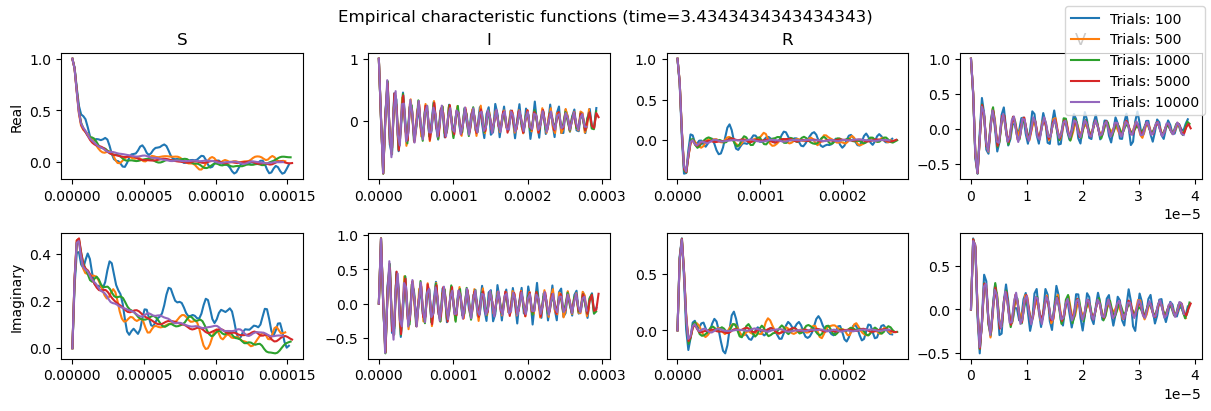

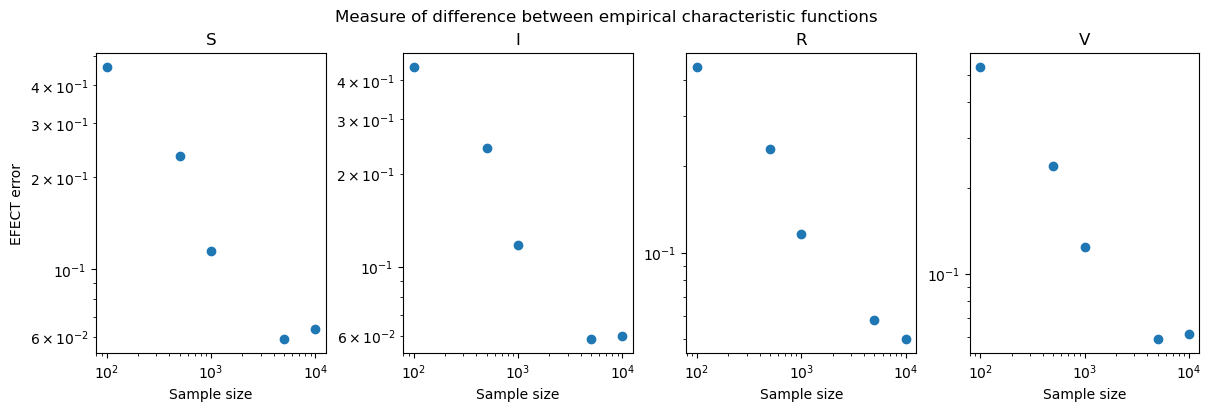

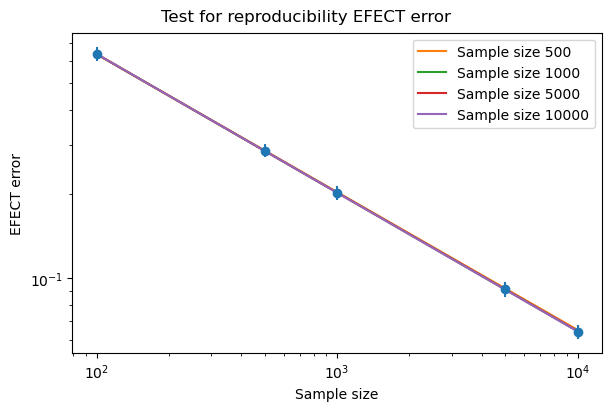

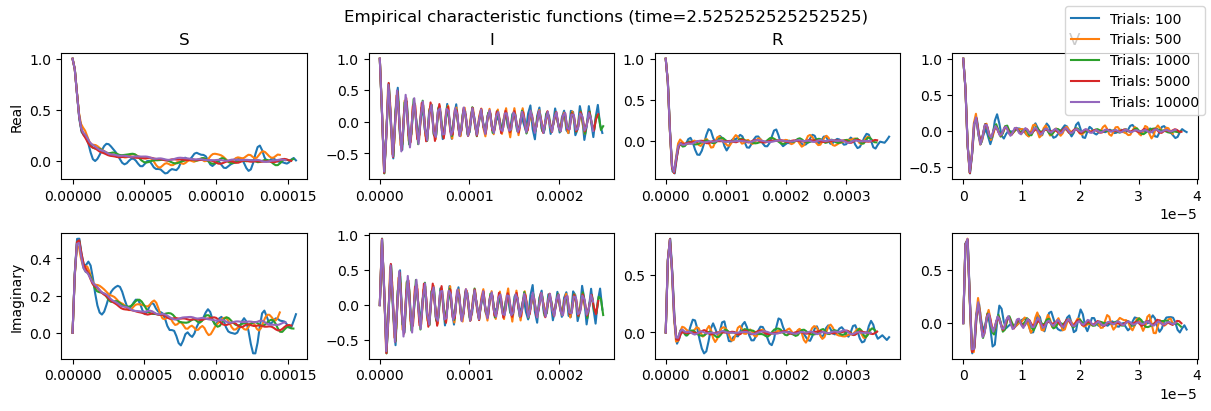

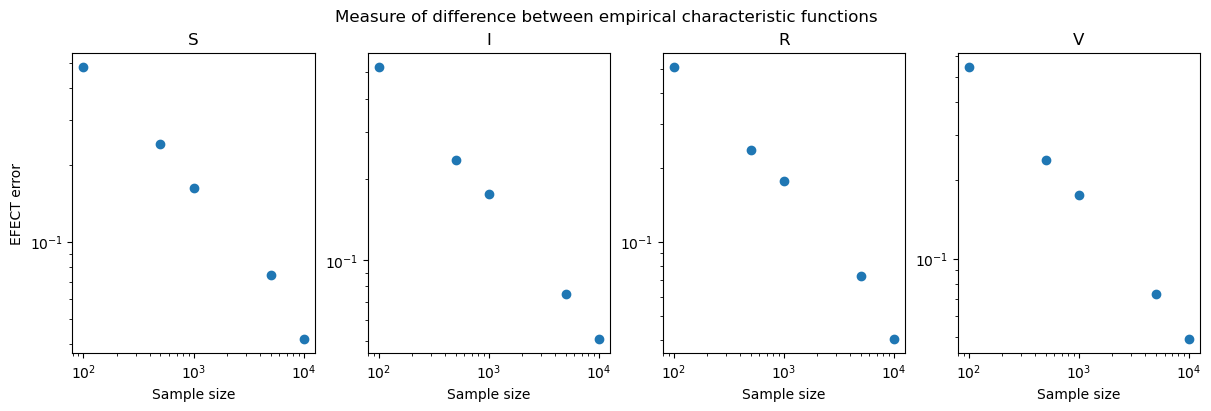

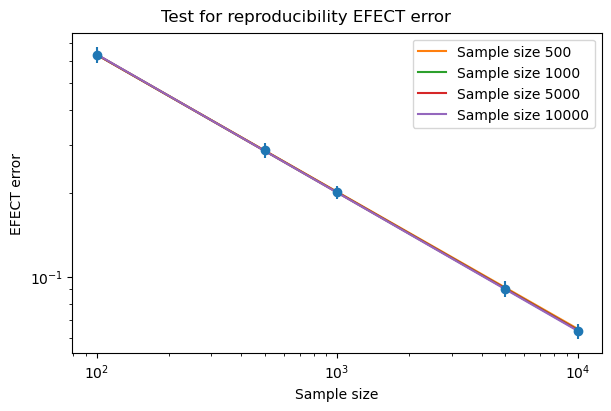

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

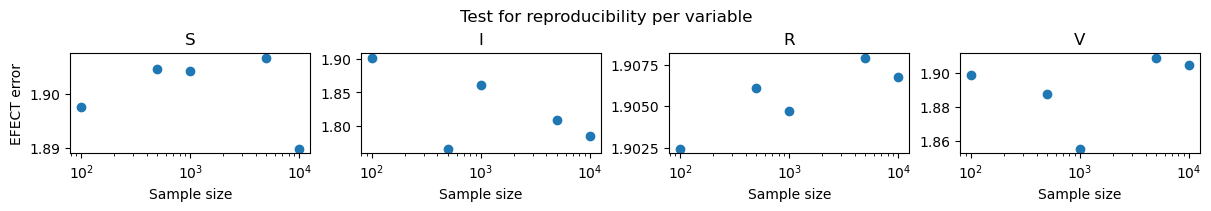

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('Sample size')
    ax[i].set_xscale('log')
    ax[i].set_title(name)
ax[0].set_ylabel('EFECT error')
_ = fig.suptitle('Test for reproducibility per variable')

Testing for how well the method can detect differences in model parameters. 

Output()

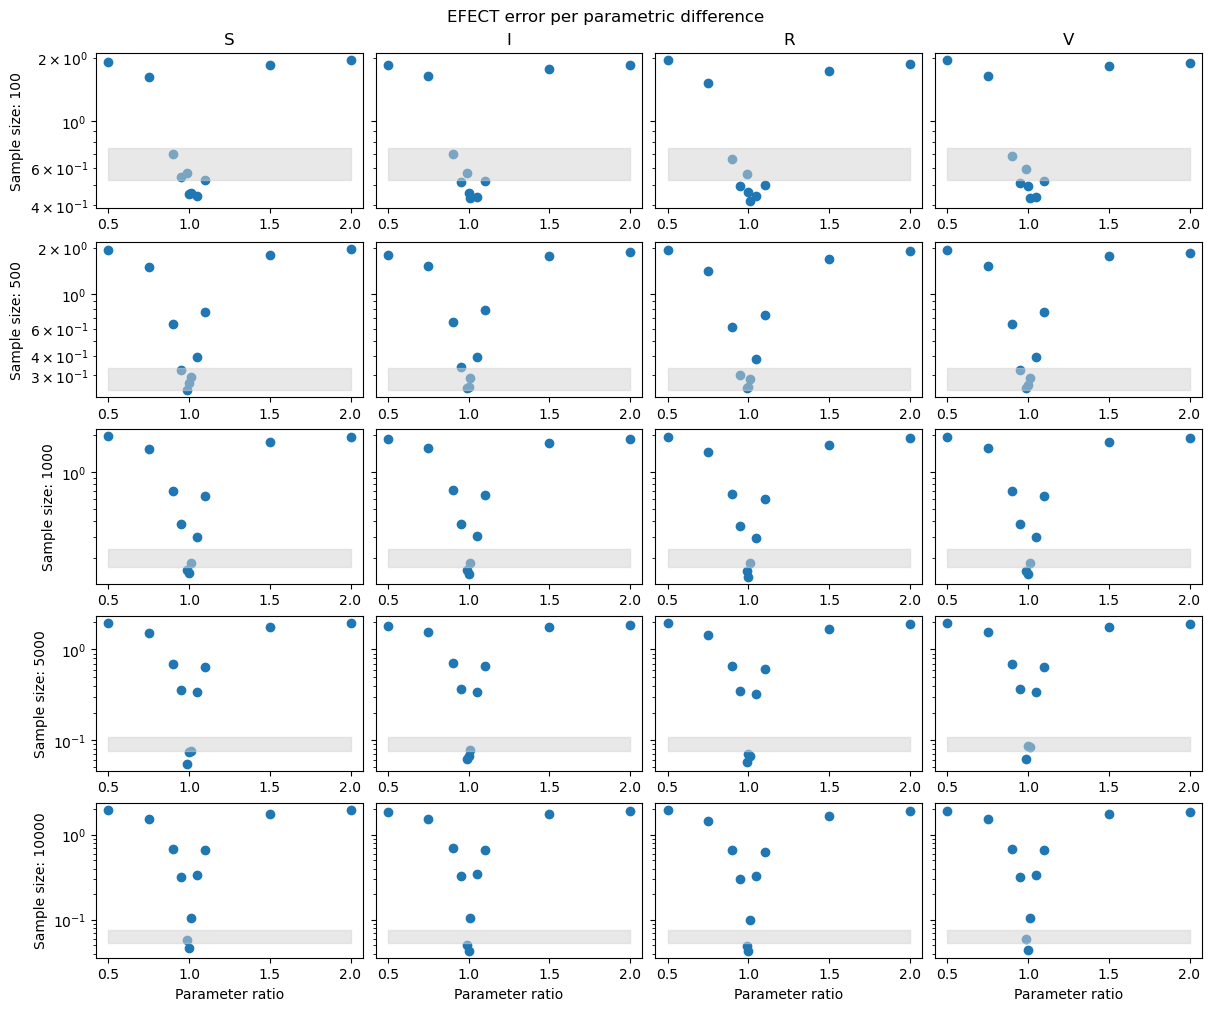

In [8]:
beta_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
beta_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in beta_fact:
    label.value = f'Factor: {bf}...'

    betatest_mean = beta1_mean * bf
    test = Test(model=model_sir({'beta': ('norm', (betatest_mean, betatest_mean / 10))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    beta_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(beta_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in beta_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(beta_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('EFECT error per parametric difference')

Report stats on detecting differences.

An upper bound on the probability of a false-positive when testing for reproducing results is calculated using Chebyshev's inequality with unknown population mean and variance. See equation 17 from 10.1007/s11222-011-9229-0. 

In [9]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'EFECT error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    sz = len(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in beta_comp]
    q2 = (sz + 1) / sz * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sz + 1) / sz * ((sz - 1) / l2 + 1)) / (sz + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(beta_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.636854,0.037467
500,0.287179,0.015594
1000,0.202437,0.011368
5000,0.091197,0.005324
10000,0.064304,0.003572


Sample size  \
Sample size Scaling factor EFECT error Standardized error Acceptance p-value                
100         0.50           1.943840     34.883453         0.002494                    100   
            0.75           1.632293     26.568283         0.002494                    100   
            0.90           0.700784     1.706277          0.346633                    100   
            0.95           0.541595    -2.542478          1.000000                    100   
            0.99           0.595647    -1.099818          1.000000                    100   
            1.00           0.495562    -3.771079          1.000000                    100   
            1.01           0.457094    -4.797802          1.000000                    100   
            1.05           0.442054    -5.199225          1.000000                    100   
            1.10           0.527944    -2.906813          1.000000                    100   
            1.50           1.841023     32.139279         0.002494                    100   
            2.00           1.947031     34.968635         0.002494                    100   
500         0.50           1.941625     106.098230        0.004975                    500   
            0.75           1.523701     79.297140         0.004975                    500   
            0.90           0.663366     24.124517         0.004975                    500   
            0.95           0.336923     3.190031          0.099502                    500   
            0.99           0.249135    -2.439742          1.000000                    500   
            1.00           0.265508    -1.389758          1.000000                    500   
            1.01           0.290516     0.214012          1.000000                    500   
            1.05           0.396012     6.979375          0.024876                    500   
            1.10           0.786267     32.006098         0.004975                    500   
            1.50           1.785603     96.092640         0.004975                    500   
            2.00           1.947012     106.443712        0.004975                    500   
1000        0.50           1.957796     154.409925        0.001664                   1000   
            0.75           1.567936     120.115982        0.001664                   1000   
            0.90           0.710023     44.649785         0.001664                   1000   
            0.95           0.382395     15.829995         0.004992                   1000   
            0.99           0.161188    -3.628439          1.000000                   1000   
            1.00           0.152288    -4.411279          1.000000                   1000   
            1.01           0.183710    -1.647279          1.000000                   1000   
            1.05           0.301394     8.704800          0.013311                   1000   
            1.10           0.649686     39.342214         0.001664                   1000   
            1.50           1.753908     136.474967        0.001664                   1000   
            2.00           1.943539     153.155851        0.001664                   1000   
5000        0.50           1.949869     349.114559        0.002494                   5000   
            0.75           1.553666     274.695692        0.002494                   5000   
            0.90           0.708906     116.024294        0.002494                   5000   
            0.95           0.365392     51.501986         0.002494                   5000   
            0.99           0.062369    -5.414858          1.000000                   5000   
            1.00           0.085628    -1.046131          1.000000                   5000   
            1.01           0.082994    -1.540934          1.000000                   5000   
            1.05           0.343449     47.380457         0.002494                   5000   
            1.10           0.654879     105.876329        0.002494             